## Convolutional Neural Nets for FKD


In [22]:
# initiate packages for NN - Theano etc.
%matplotlib inline

import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import time
import cPickle as pickle

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
device = theano.config.device # We're using CPUs (for now)
floatConf = theano.config.floatX # Should be 64 bit for CPUs

# due to theano errors, we are forcing this to be float32
'''if (theano.config.floatX == 'float32'):
    floatConf = np.float32
else:
    floatConf = np.float64'''
floatConf = np.float32

np.random.seed(0)

### 1. Single Hidden Layer

In [23]:
# load data

import sys, os

pathArr = os.getcwd().split("/")
scriptPath = '/'.join(map(str, pathArr[:len(pathArr)-1]))
sys.path.append(scriptPath)

# import submit module from our tools subfolder
from tools import submit, getdata
# load data

_loaded = getdata.load_data(0, test=True, nonas=True)

FEATURES = _loaded['features']
print 'Number of features:', len(FEATURES)

# load and scale pixel values to [0, 1]
train_data = np.vstack(_loaded['training']['data']) / 255.
train_data = train_data.astype(floatConf)

# load and scale target coordinates to [-1, 1]
train_labels = _loaded['training']['labels']
train_labels = (train_labels - 48) / 48
train_labels = train_labels.astype(floatConf)
    
print 'Training dataset size: ', train_data.shape

test_data = np.vstack(_loaded['test']['data']) / 255.
test_data = test_data.astype(floatConf)

print 'Test dataset size: ', test_data.shape

Number of features: 30
Training dataset size:  (2140, 9216)
Test dataset size:  (1783, 9216)


In [24]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  
    hidden_num_units=100,
    output_nonlinearity=None, 
    output_num_units=30,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net1.fit(train_data, train_labels)

  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 100)         	produces     100 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.19691       0.04218      4.66831  0.45s
      2       0.02556       0.01639      1.55909  0.51s
      3       0.01391       0.01445      0.96274  0.48s
      4       0.01286       0.01323      0.97249  0.46s
      5       0.01191       0.01225      0.97223  0.47s
      6       0.01133       0.01162      0.97513  0.47s
      7       0.01092       0.01114      0.97993  0.47s
      8       0.01058       0.01078      0.98139  0.52s
      9       0.01029       0.01047      0.98262  0.49s
     10       0.01003       0.01016      0.98760  0.50s
     11       0.00979       0.00989      0.99069  0.48s
     12       0.00957       0.00971      0.98612  0.48s
     13       0.0

NeuralNet(X_tensor_type=<function matrix at 0x10c83d6e0>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10d0f3990>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10d095c50>,
     custom_score=None, eval_size=0.2, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x10d0e7cf8>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x1136f47a0>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x10d06d488>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False, verbose=1,
     y

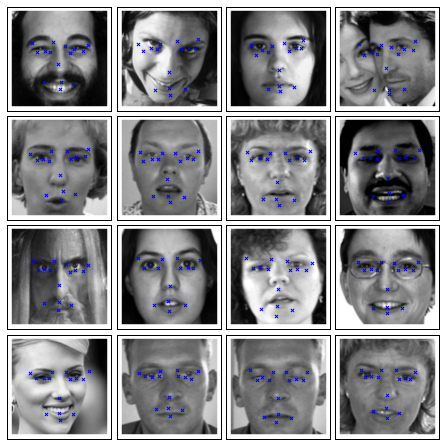

In [25]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

y_pred = net1.predict(test_data)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()

### 2. Convolutions

In [ ]:
train_data_2d = train_data.reshape(-1, 1, 96, 96)

net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=1000,
    verbose=1,
    )

net2.fit(train_data_2d, train_labels)

# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
import cPickle as pickle
with open('cnn_fkd.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)